In [10]:
import os

if 'main_dir' in globals():
    os.chdir(main_dir)

import pandas as pd
from utils.load_config import load_exp_config, get_value_from_fields, get_df_historical_data
import matplotlib

%matplotlib inline

if os.getcwd().endswith("notebooks"):
    main_dir = os.getcwd()
    os.chdir("..")

In [11]:
file_path="/home/tcc/huyhoang/regelum-playground/regelum_data/outputs/2024-08-08/18-54-51/0/.callbacks/ValueCallback/Total_Objectives_in_iteration_00001.h5"
file_path="regelum_data/outputs/2024-08-08/21-18-31/0/.callbacks/HistoricalDataCallback/observations_actions_it_00001_ep_00001.h5"

file_path="/home/tcc/huyhoang/regelum-control/regelum_data/outputs/2024-08-12/18-28-16__ppo_3wrobot_kin/0/.callbacks/HistoricalDataCallback/observations_actions_it_00106_ep_00010.h5"

In [12]:
exp_path="/home/tcc/huyhoang/regelum-control/regelum_data/outputs/2024-08-12/18-28-16__ppo_3wrobot_kin/0"
chosen_name="observations_actions_it_00106_ep_00010"
df = get_df_historical_data(exp_path, chosen_name)

ref_exp_path="/home/tcc/huyhoang/regelum-control/regelum_data/outputs/2024-08-13/09-34-20__nominal_3wrobot_kin/0"
ref_chosen_name="observations_actions_it_00001"
ref_df = get_df_historical_data(ref_exp_path, ref_chosen_name)

## Get sampling time

In [13]:
def get_sampling_time(exp_path):
    config = load_exp_config(exp_path)

    sampling_time = config['scenario']['sampling_time']
    if "$" in sampling_time:
        correct_fields = sampling_time.strip("\{\}$").split(".")
        sampling_time = get_value_from_fields(config, correct_fields)

    return sampling_time

sampling_time = get_sampling_time(exp_path)
ref_sampling_time = get_sampling_time(ref_exp_path)

## Re-calculate objective

### Define objective function

In [14]:
from regelum.objective import RunningObjective
from regelum.model import ModelQuadLin
import numpy as np


objective_function = RunningObjective(ModelQuadLin(
    weights= [2, 10, 0, 0, 0],
    quad_matrix_type="diagonal",
    is_with_linear_terms=False,
))

observation = np.array([[1, 1, 0.01]])
actions = np.array([[1, 1]])
objective_function(observation, actions)

12.0

### Calculate Objective

In [15]:
def cal_obj_df(row):
    observation = np.expand_dims(np.array(row.loc[["x [m]", "y [m]", "angle [rad]"]].values), axis=0)
    action = np.expand_dims(np.array(row.loc[["velocity [m/s]", "angular velocity [rad/s]"]].values), axis=0)
    
    return objective_function(observation, action)

df["current_value"] = df.apply(cal_obj_df, axis=1)
df["running_objective"] = df["current_value"].apply(lambda x: x*sampling_time).cumsum()

ref_df["current_value"] = ref_df.apply(cal_obj_df, axis=1)
ref_df["running_objective"] = ref_df["current_value"].apply(lambda x: x*ref_sampling_time).cumsum()

In [16]:
df

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad]
0,0.00,1.080000,108.000000,10,106,-1.115760,0.723488,3.000000,3.000000,2.356194
1,0.01,2.156241,107.624100,10,106,-0.875706,0.938147,3.007918,2.992139,2.363429
2,0.02,3.229579,107.333828,10,106,-4.358105,0.255229,3.014184,2.986021,2.372811
3,0.03,4.288739,105.915936,10,106,-0.583200,-0.648437,3.045547,2.955761,2.375363
4,0.04,5.346012,105.727298,10,106,-7.189816,0.510280,3.049736,2.951703,2.368879
...,...,...,...,...,...,...,...,...,...,...
496,4.96,157.320101,7.123734,10,106,-2.155487,0.509282,-1.536747,0.489954,0.159346
497,4.97,157.392315,7.221479,10,106,-0.483431,0.692913,-1.558020,0.486480,0.164439
498,4.98,157.464749,7.243375,10,106,-2.874652,1.267953,-1.562786,0.485672,0.171368
499,4.99,157.538476,7.372742,10,106,-4.983374,0.608264,-1.591080,0.480590,0.184047


## Plot objective

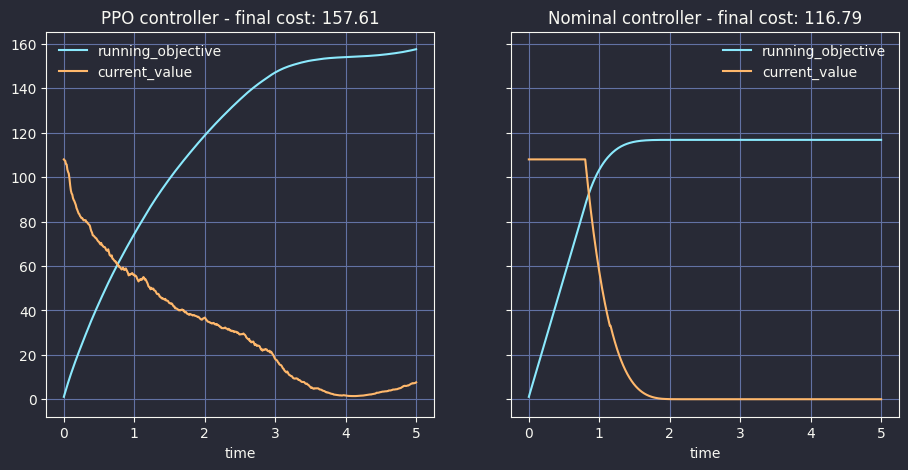

In [27]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
ax[0].set_title("PPO controller - final cost: {:0.2f}".format(df.running_objective.max()))
df.plot(x="time", y="running_objective", ax=ax[0])
df.plot(x="time", y="current_value", ax=ax[0])

ax[1].set_title("Nominal controller - final cost: {:0.2f}".format(ref_df.running_objective.max()))
ref_df.plot(x="time", y="running_objective", ax=ax[1])
ref_df.plot(x="time", y="current_value", ax=ax[1])

for _ax in ax:
    _ax.grid()

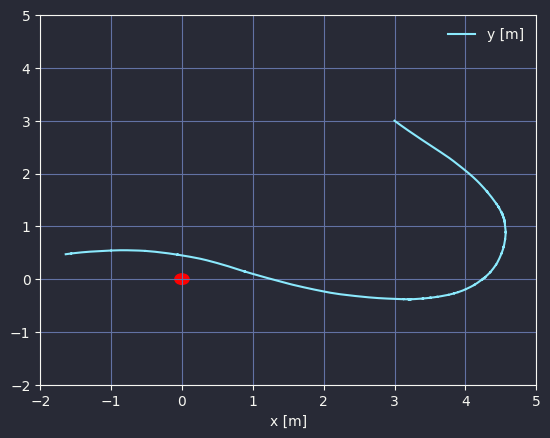

In [18]:

fig, ax = plt.subplots()
df.plot(x="x [m]", y="y [m]", ax=ax)
circle = plt.Circle((0, 0), 0.1, color="red")
ax.add_patch(circle)
ax.set_xlim(-2, 5)
ax.set_ylim(-2, 5)
ax.grid()